In [ ]:
import numpy as np
import networkx as nx
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import chain

In [2]:
def image_to_graph(image_path, threshold = 127):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    _, binarized_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    G = nx.Graph()
    
    height, width = binarized_img.shape
    
    for y in range(height):
        for x in range(width):
            if binarized_img[y, x] == 255:
                G.add_node((x, y))
                
                neighbors = [
                    (x + 1, y),
                    (x, y + 1),
                    (x + 1, y + 1)
                ]
                
                for n_x, n_y in neighbors:
                    if 0 <= n_x < width and 0 <= n_y < height and binarized_img[n_y, n_x] == 255:
                        G.add_edge((x, y), (n_x, n_y)) 
    
    return G, binarized_img

In [4]:
def get_adjacent_junction(component, junction_components):
    edges = []
    meta_edges = set()
    for junc_id, junction in junction_components.items():
        for jpx in junction:
            x, y = jpx
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    n = (x + i, y + j)
                    if n in component:
                        edges.append((jpx, n))
                        meta_edges.add(junc_id)
    return edges, meta_edges

In [14]:
def display_component(meta_graph, label, title=None):
    """
    Displays a single conduction region or junction by label.
    """
    if label not in meta_graph:
        print(f"Label '{label}' not found in meta_graph.")
        return

    component = meta_graph.nodes[label]['pixels']
    subgraph = G.subgraph(component).copy()
    pos = {node: node for node in subgraph.nodes}
    
    plt.figure(figsize=(5, 5))
    nx.draw(subgraph, pos, with_labels=False, node_size=10, node_color='black')
    plt.title(title or f"Component: {label}")
    plt.axis('equal')
    plt.show()

In [ ]:
def display_all_components(meta_graph, G, include_junctions=False):
    """
    Displays all components (optionally including junctions) using their stored pixel sets.
    """
    labels_to_display = [
        label for label in meta_graph.nodes
        if meta_graph.nodes[label]['type'] == 'region' or (include_junctions and meta_graph.nodes[label]['type'] == 'junction')
    ]
    
    colors = list(mcolors.TABLEAU_COLORS.values())
    plt.figure(figsize=(8, 8))

    for i, label in enumerate(labels_to_display):
        component = meta_graph.nodes[label]['pixels']
        subgraph = G.subgraph(component).copy()
        pos = {node: node for node in subgraph.nodes}
        nx.draw(subgraph, pos, with_labels=False, node_size=10, node_color=colors[i % len(colors)], label=label)

    plt.legend(bbox_to_anchor=(1.01, 1.01))
    plt.axis('equal')
    plt.title("All Components of the Conduction System")
    plt.show()


In [5]:
G, _ = image_to_graph("CCS.png")
G_parts, _ = image_to_graph("CCS_parts.png", threshold=110)

In [6]:
# Identify components (parts of the conduction system)
components = [c for c in sorted(nx.connected_components(G_parts), key=len, reverse=True)][:9]
# The labels list was made AFTER some visualizations of the components
labels = [
    "his_left", "his_right", "bachmann", "internodal_post",
    "his_bundle", "sa_node", "av_node", "internodal_ant", "internodal_mid"
]
component_dict = dict(zip(labels, components))

In [7]:
# Retain only largest connected portion of original G
G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

In [8]:
# Isolate junction points (pixels not part of labeled components)
component_pixels = set(chain.from_iterable(components))
junction_points = set(G.nodes) - component_pixels

In [9]:
# Split junction area into its own connected components
junction_components = {
    i: c for i, c in enumerate(nx.connected_components(G.subgraph(junction_points)))
}

In [10]:
# Create meta_graph
meta_graph = nx.Graph()
meta_labels = {}

In [11]:
# Add junctions as meta-nodes
for i, junction in junction_components.items():
    label = f"junction_{i}"
    meta_graph.add_node(label, type="junction", pixels=junction)
    meta_labels[label] = label

# Add conduction regions as meta-nodes
for label, component in component_dict.items():
    meta_graph.add_node(label, type="region", pixels=component)
    meta_labels[label] = label

    # Add meta-edges from region to junctions
    edges, connected_junction_ids = get_adjacent_junction(component, junction_components)
    for jid in connected_junction_ids:
        j_label = f"junction_{jid}"
        meta_graph.add_edge(label, j_label, raw_edges=edges)

/var/folders/sk/nz4kyqdn0912990ksglz44c00000gn/T/ipykernel_70468/2171142445.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


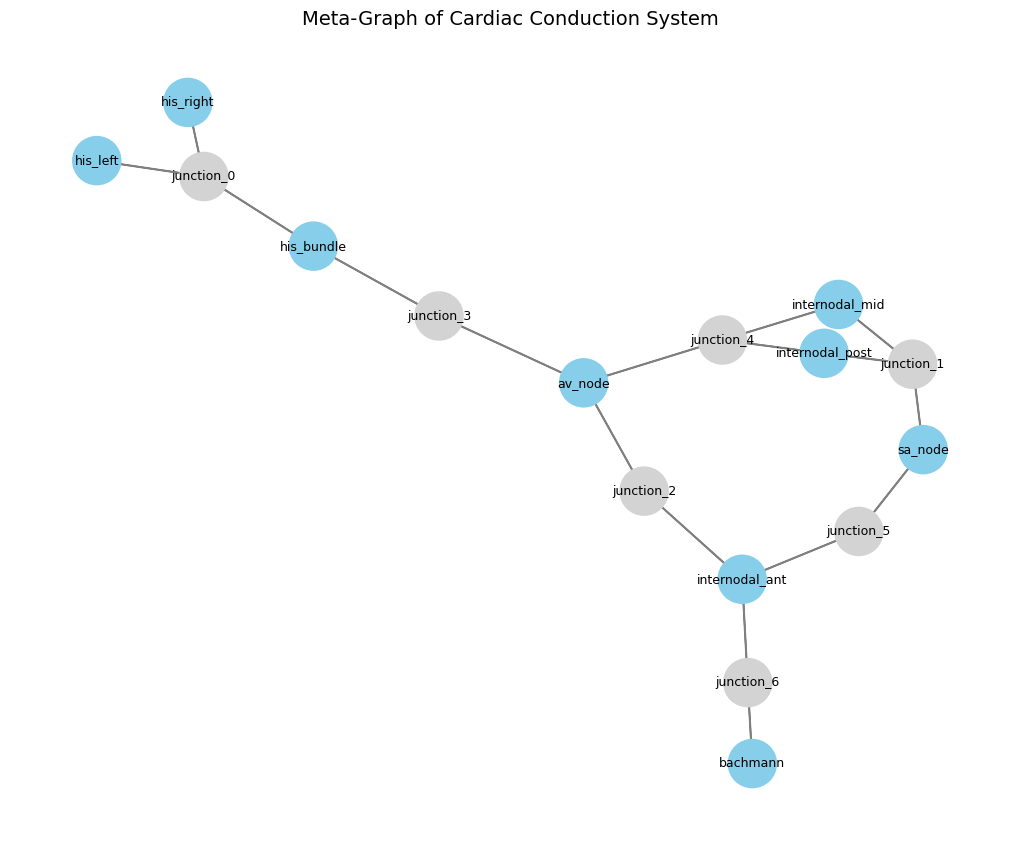

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(meta_graph, seed=42)

# Different colors for conduction system parts vs. junction nodes
color_map = ['skyblue' if meta_graph.nodes[n]['type'] == 'region' else 'lightgray' for n in meta_graph.nodes]

nx.draw(meta_graph, pos, with_labels=True, labels=meta_labels, node_color=color_map, node_size=1200, font_size=9)
nx.draw_networkx_edges(meta_graph, pos, width=1.5, edge_color='gray', style='solid')

plt.title("Meta-Graph of Cardiac Conduction System", fontsize=14)
plt.tight_layout()
plt.show()

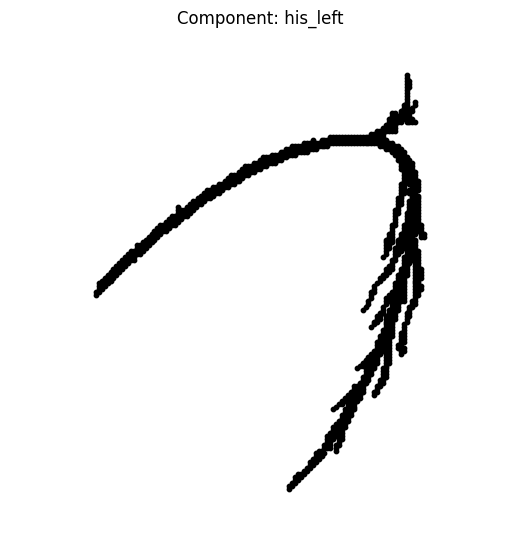

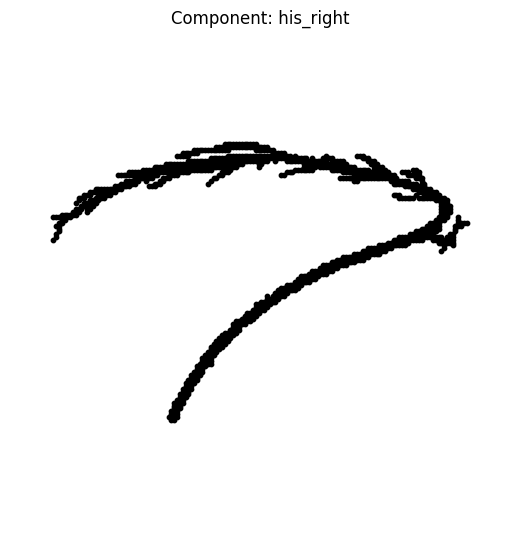

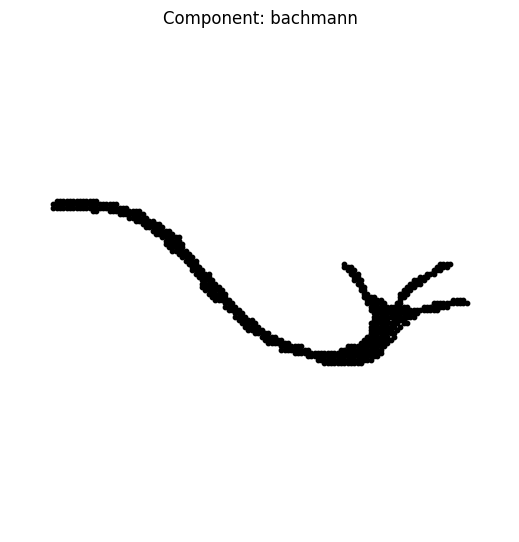

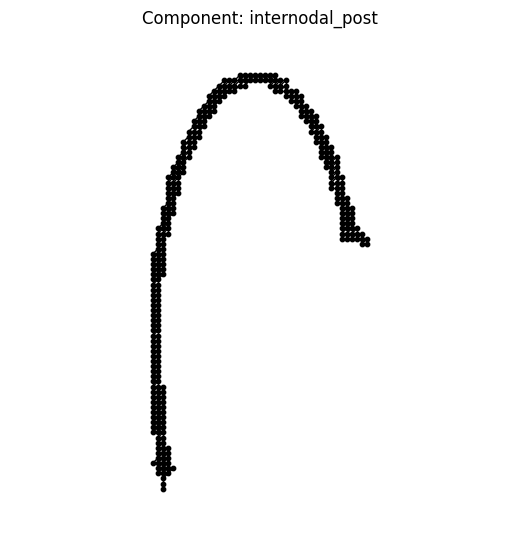

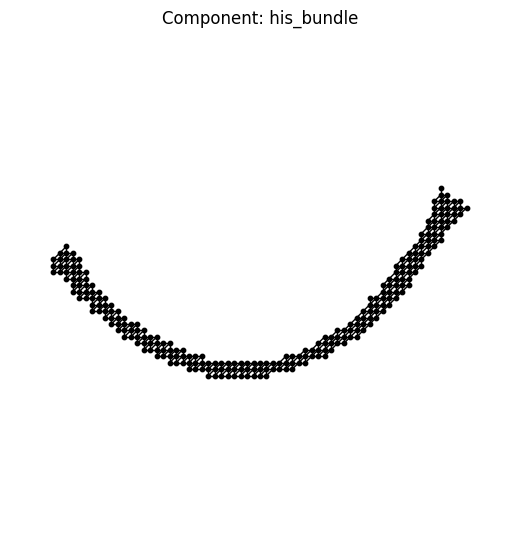

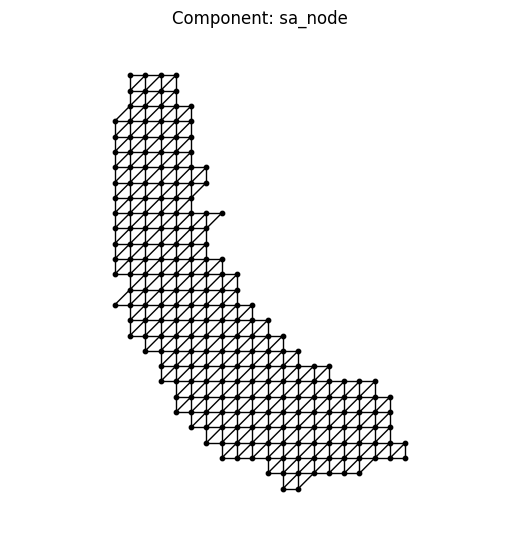

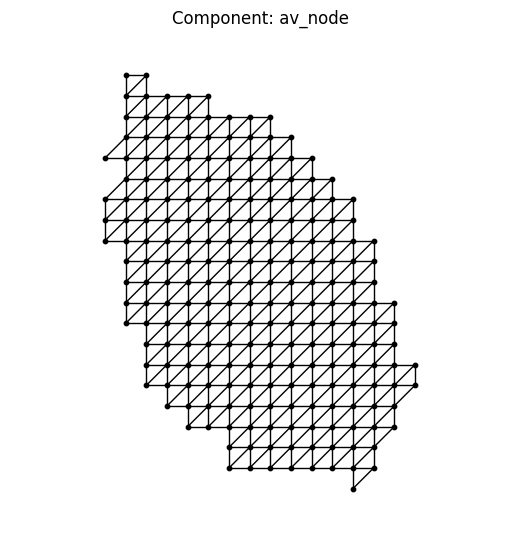

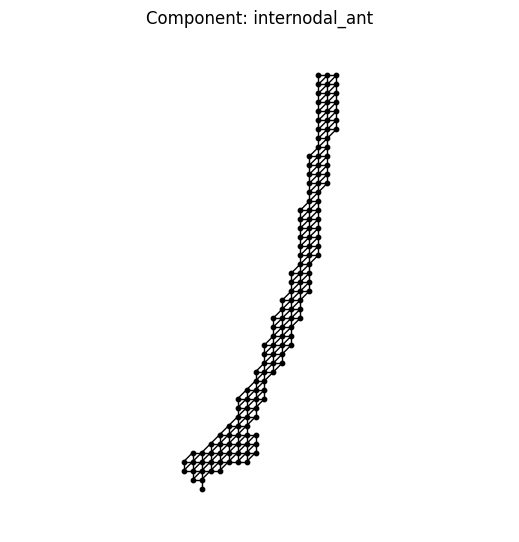

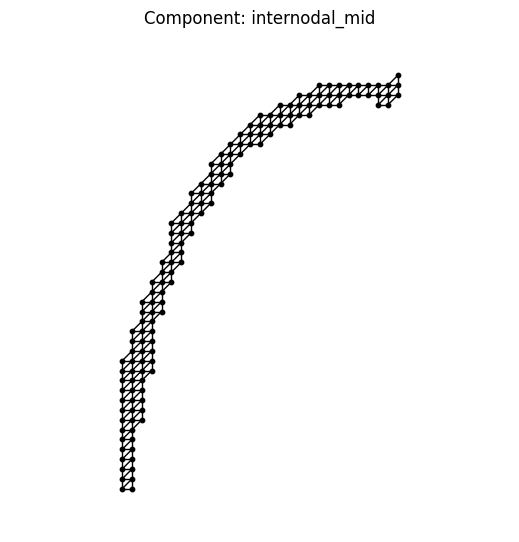

In [17]:
for component in component_dict:
    display_component(meta_graph, component)

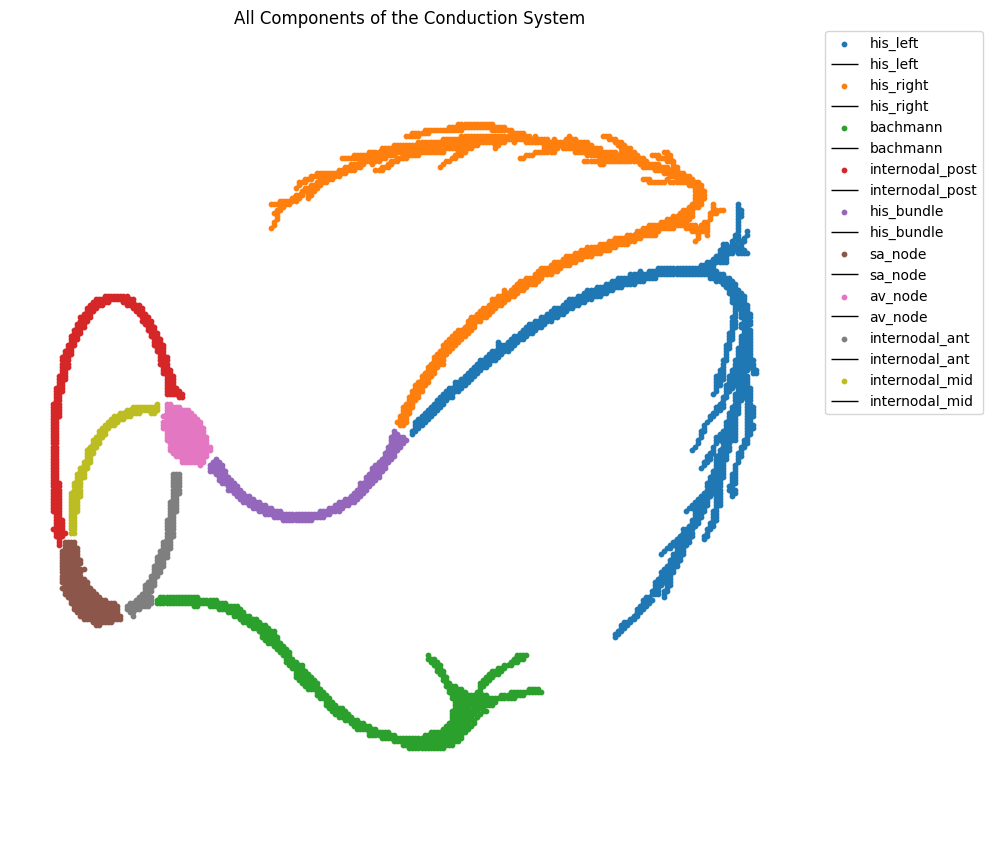

In [18]:
# Show all conduction regions (no junctions)
display_all_components(meta_graph, G)

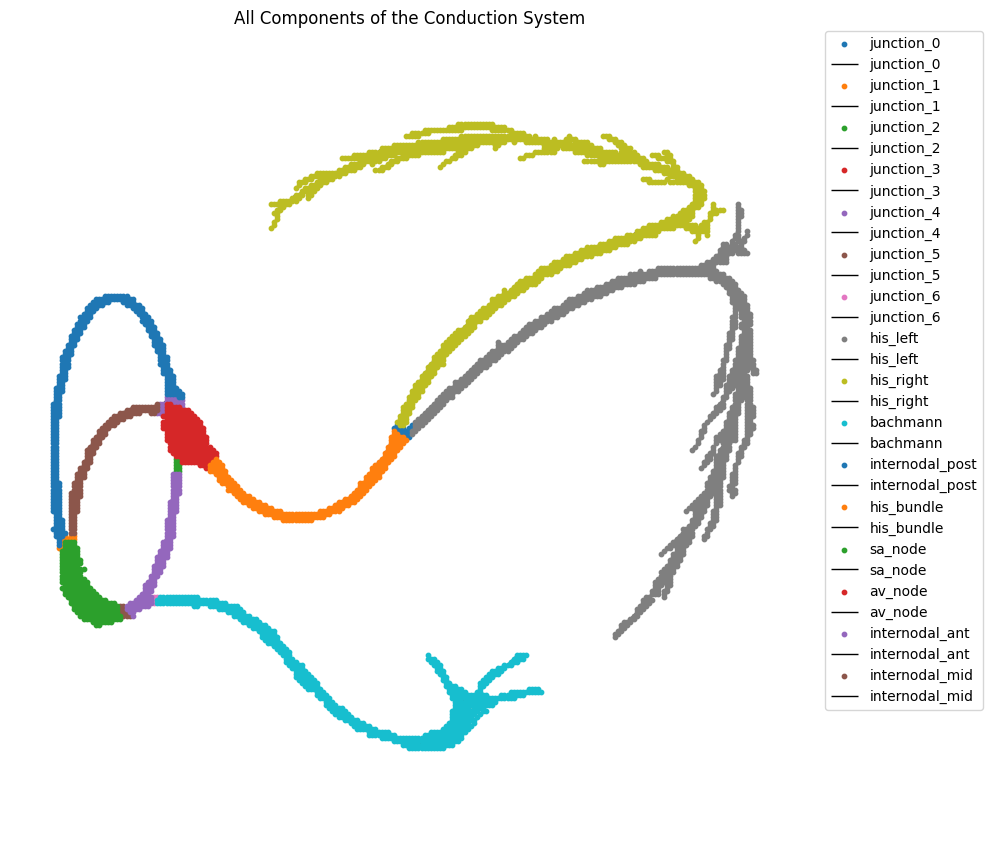

In [19]:
# Optionally, show all including junctions:
display_all_components(meta_graph, G, include_junctions=True)

In [ ]:
# with the help of ChatGPT
def display_raw_edges_between(meta_graph, G, region_label, junction_label, show_nodes=True):
    """
    Visualizes raw pixel-level connections between a region and a junction.
    """
    if not meta_graph.has_edge(region_label, junction_label):
        print(f"No edge between '{region_label}' and '{junction_label}' in meta_graph.")
        return

    region_nodes = meta_graph.nodes[region_label]['pixels']
    junction_nodes = meta_graph.nodes[junction_label]['pixels']
    raw_edges = meta_graph[region_label][junction_label].get('raw_edges', [])

    region_graph = G.subgraph(region_nodes)
    junction_graph = G.subgraph(junction_nodes)

    pos = {node: node for node in G.nodes}

    plt.figure(figsize=(6, 6))

    if show_nodes:
        nx.draw(region_graph, pos, node_color='skyblue', node_size=10, label=region_label)
        nx.draw(junction_graph, pos, node_color='lightgray', node_size=10, label=junction_label)

    # Draw raw edges between region and junction
    raw_edge_lines = [(a, b) for a, b in raw_edges if a in junction_nodes and b in region_nodes]
    nx.draw_networkx_edges(G, pos, edgelist=raw_edge_lines, edge_color='red', style='dashed', width=1.5)

    plt.title(f"Raw Connections: {region_label} ↔ {junction_label}")
    plt.legend()
    plt.axis('equal')
    plt.show()


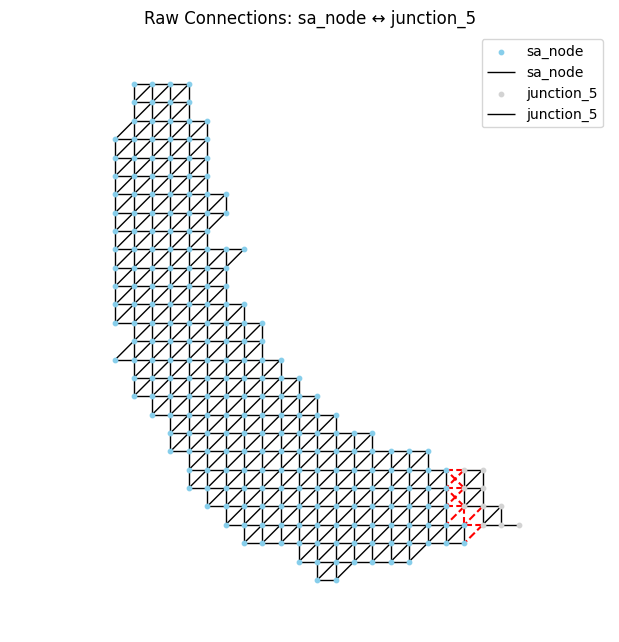

In [22]:
display_raw_edges_between(meta_graph, G, "sa_node", "junction_5")